<a href="https://colab.research.google.com/github/minjeong-kim-git/HUFS-RL-2022/blob/main/Day%2003/01_REINFORCE%2BA2C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reinforce & Advantage Actor Critic (A2C)

[You can find the original paper here](https://arxiv.org/pdf/1602.01783.pdf).

## Install, import and utilities

In [1]:
!pip install torch==1.1.0 torchvision pyvirtualdisplay matplotlib seaborn pandas numpy pathlib gym
!sudo apt-get install xvfb

Reading package lists... Done
Building dependency tree       
Reading state information... Done
xvfb is already the newest version (2:1.19.6-1ubuntu4.10).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F 
from torch import optim
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay
from IPython.display import clear_output
from pathlib import Path

import random, os.path, math, glob, csv, base64, itertools, sys
import gym
from gym.wrappers import Monitor
from pprint import pprint

# The following code is will be used to visualize the environments.

def show_video(directory):
    html = []
    for mp4 in Path(directory).glob("*.mp4"):
        video_b64 = base64.b64encode(mp4.read_bytes())
        html.append('''<video alt="{}" autoplay 
                      loop controls style="height: 400px;">
                      <source src="data:video/mp4;base64,{}" type="video/mp4" />
                 </video>'''.format(mp4, video_b64.decode('ascii')))
    ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))
    
display = Display(visible=0, size=(1400, 900))
display.start();

def make_seed(seed):
    np.random.seed(seed=seed)
    torch.manual_seed(seed=seed)

The following code is will be used to visualize the environments.

## Introduction

In this tutorial we will focus on Deep Reinforcement Learning with **Reinforce** and the **Actor-Advantage Critic** algorithm. This tutorial is composed of:
* An introduction to the deep learning framework: **PyTorch**, 
* A quick reminder of the RL setting,
* A theoritical and coding approch of Reinforce
* A theoritical and coding approch of A2C.

## Introduction to PyTorch

*If you already know PyTorch you can skip this part. From this part on we assume that you have some experience with Python and Numpy. This part is extracted from PyTorch docs.*

PyTorch is a Python package that provides two high-level features:
- Tensor computation (like NumPy) with strong GPU acceleration
- Deep neural networks built on a tape-based autograd system

At a granular level, PyTorch is a library that consists of the following components:

| Component | Description |
| ---- | --- |
| [**torch**](https://pytorch.org/docs/stable/torch.html) | a Tensor library like NumPy, with strong GPU support |
| [**torch.autograd**](https://pytorch.org/docs/stable/autograd.html) | a tape-based automatic differentiation library that supports all differentiable Tensor operations in torch |
| [**torch.jit**](https://pytorch.org/docs/stable/jit.html) | a compilation stack (TorchScript) to create serializable and optimizable models from PyTorch code  |
| [**torch.nn**](https://pytorch.org/docs/stable/nn.html) | a neural networks library deeply integrated with autograd designed for maximum flexibility |
| [**torch.multiprocessing**](https://pytorch.org/docs/stable/multiprocessing.html) | Python multiprocessing, but with magical memory sharing of torch Tensors across processes. Useful for data loading and Hogwild training |
| [**torch.utils**](https://pytorch.org/docs/stable/data.html) | DataLoader and other utility functions for convenience |



PyTorch works in a very similar way as Numpy and PyTorch's Tensors are the equivalent of Numpy's Arrays.

You can initialize an zero filled tensor just like in numpy.

In [3]:
torch.zeros(5,3)

tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])

In [4]:
torch.eye(3)

tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]])

You can also convert an array to a tensor.

In [5]:
torch.tensor(np.eye(3))

tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], dtype=torch.float64)

And you can transform a tensor to an array.

In [6]:
torch.tensor(np.eye(3)).numpy()

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

You can sum, substract, multiply arrays just like in numpy.

In [7]:
a = torch.randint(0,10,(2,3))
print(a)

tensor([[2, 8, 4],
        [7, 5, 0]])


In [8]:
b = torch.randint(0,10,(2,3))
print(b)

tensor([[3, 7, 0],
        [2, 9, 2]])


In [9]:
print(f'a + b = {a + b}')
print(f'a * b = {a * b}')

a + b = tensor([[ 5, 15,  4],
        [ 9, 14,  2]])
a * b = tensor([[ 6, 56,  0],
        [14, 45,  0]])


You can make matrix products.

In [10]:
a @ b.t()

tensor([[62, 84],
        [56, 59]])

### AUTOGRAD: automatic differentiation

The autograd package provides automatic differentiation for all operations on Tensors. It is a define-by-run framework, which means that your backprop is defined by how your code is run, and that every single iteration can be different.

``torch.Tensor`` is the central class of the package. If you set its attribute
``.requires_grad`` as ``True``, it starts to track all operations on it. When
you finish your computation you can call ``.backward()`` and have all the
gradients computed automatically. The gradient for this tensor will be
accumulated into ``.grad`` attribute.

To stop a tensor from tracking history, you can call ``.detach()`` to detach
it from the computation history, and to prevent future computation from being
tracked.

To prevent tracking history (and using memory), you can also wrap the code block
in ``with torch.no_grad():``. This can be particularly helpful when evaluating a
model because the model may have trainable parameters with
``requires_grad=True``, but for which we don't need the gradients.

There’s one more class which is very important for autograd
implementation - a ``Function``.

``Tensor`` and ``Function`` are interconnected and build up an acyclic
graph, that encodes a complete history of computation. Each tensor has
a ``.grad_fn`` attribute that references a ``Function`` that has created
the ``Tensor`` (except for Tensors created by the user - their
``grad_fn is None``).

If you want to compute the derivatives, you can call ``.backward()`` on
a ``Tensor``. If ``Tensor`` is a scalar (i.e. it holds a one element
data), you don’t need to specify any arguments to ``backward()``,
however if it has more elements, you need to specify a ``gradient``
argument that is a tensor of matching shape.

## Reminder of the RL setting

As always we will consider a MDP $M = (\mathcal{S}, \mathcal{A}, p, r, \gamma)$ with:
* $\mathcal{S}$ the state space,
* $\mathcal{A}$ the action space,
* $p(x^\prime \mid x, a)$ the transition probability,
* $r(x, a, x^\prime)$ the reward of the transition $(x, a, x^\prime)$,
* $\gamma \in [0,1)$ is the discount factor.

A policy $\pi$ is a mapping from the state space $\mathcal{S}$ to the probability of selecting each action.

The action value function of a policy is the overall expected reward from a state action. $Q^\pi(s, a) = \mathbb{E}_{\tau \sim \pi}\big[R(\tau) \mid s_0=s, a_0=a\big]$ where $\tau$ is an episode $(s_0, a_0, r_0, s_1, a_1, r_1, s_2, ..., s_T, a_T, r_T)$ with the actions drawn from $\pi(s)$; $R(\tau)$ is the random variable defined as the cumulative sum of the discounted reward.

The goal is to maximize the agent's reward.

$$ J(\pi) = \mathbb{E}_{\tau \sim \pi}\big[R(\tau) \big]$$

## Gym Environment

In this lab and also the next one we are going to use the [OpenAI's Gym library](https://gym.openai.com/envs/). This library provides a large number of environments to test RL algorithm.

We will focus on the **CartPole-v1** environment in this lab but we encourage you to also test your code on:
* **Acrobot-v1**
* **MountainCar-v0**

| Env Info          	| CartPole-v1 	| Acrobot-v1                	| MountainCar-v0 	|
|-------------------	|-------------	|---------------------------	|----------------	|
| **Observation Space** 	| Box(4)      	| Box(6)                    	| Box(2)         	|
| **Action Space**      	| Discrete(2) 	| Discrete(3)               	| Discrete(3)    	|
| **Rewards**           	| 1 per step  	| -1 if not terminal else 0 	| -1 per step    	|

A gym environment is loaded with the command `env = gym.make(env_id)`. Once the environment is created, you need to reset it with `observation = env.reset()` and then you can interact with it using the method step: `observation, reward, done, info = env.step(action)`.

### Carpole

In [11]:
# We load CartPole-v1
env = gym.make('CartPole-v1')
# We wrap it in order to save our experiment on a file.
env = Monitor(env, "./gym-results", force=True, video_callable=lambda episode: True)

In [12]:
done = False
obs = env.reset()
while not done:
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
env.close()
show_video("./gym-results")

### Acrobot-v1

In [13]:
# We load Acrobot-v1
env = gym.make('Acrobot-v1')
# We wrap it in order to save our experiment on a file.
env = Monitor(env, "./gym-results", force=True, video_callable=lambda episode: True)

In [14]:
done = False
obs = env.reset()
while not done:
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
env.close()
show_video("./gym-results")

### MountainCar-v0

In [15]:
# We load Acrobot-v1
env = gym.make('MountainCar-v0')
# We wrap it in order to save our experiment on a file.
env = Monitor(env, "./gym-results", force=True, video_callable=lambda episode: True)

In [16]:
done = False
obs = env.reset()
while not done:
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
env.close()
show_video("./gym-results")

## REINFORCE

### Introduction

Reinforce is an actor-based **on policy** method. The policy $\pi_{\theta}$ is parametrized by a function approximator (e.g. a neural network).

Recall: $$ J(\pi) = \mathbb{E}_{\tau \sim \pi}\big[ \sum_{t} \gamma^t R_t \mid x_0, \pi \big].$$

To update the parameters $\theta$ of the policy, one has to do gradient ascent: $\theta_{k+1} = \theta_{k} + \alpha \nabla_{\theta}J(\pi_{\theta})|_{\theta_{k}}$.

**Advantages of this approach:**
- Compared to a Q-learning approach, here the policy is directly parametrized so a small change of the parameters will not dramatically change the policy whereas this is not the case for Q-learning approaches.
- The stochasticity of the policy allows exploration. In off policy learning, one has to deal with both a behaviour policy and an exploration policy.

### Policy Gradient Theorem

**Q.1: Prove the Policy Gradient Theorem:** $$ \nabla_{\theta} J(\pi_{\theta}) = \mathbb{E}_{\tau \sim \pi_{\theta}}\left[{\sum_{t=0}^{T} \nabla_{\theta} \log \pi_{\theta}(a_t |s_t) R(\tau)}\right]$$


The policy gradient can be approximated with:
$$ \hat{g} = \frac{1}{|\mathcal{D}|} \sum_{\tau \in \mathcal{D}} \sum_{t=0}^{T} \nabla_{\theta} \log \pi_{\theta}(a_t |s_t) R(\tau) $$

#### Hint 1

The probability of a trajectory $\tau = (s_{0}, a_{0},\dots, s_{T+1}$) with action chosen from $\displaystyle \pi_{\theta}$ is $P(\tau|\theta) = \rho_{0}(s_{0})\prod_{t=0}^{T}P\left(s_{t+1}|s_{t}, a_{t}\right) \pi_{\theta}(a_{t}|s_{t})$

#### Hint 2

Gradient-log trick: $  \nabla_{\theta}P(\tau|\theta)= P(\tau|\theta)\nabla_{\theta}\log P(\tau|\theta). $

The policy gradient can therefore be approximated with:
$$ \hat{g} = \frac{1}{|\mathcal{D}|} \sum_{\tau \in \mathcal{D}} \sum_{t=0}^{T} \nabla_{\theta} \log \pi_{\theta}(a_t |s_t) R(\tau) $$

### Implementation of vanilla REINFORCE

**Q.2: Implement the REINFORCE algorithm**

The code is splitted in two parts:
* The Model class defines the architecture of our neural network which takes as input the current state and returns the policy,
* The Agent class is responsible for the training and evaluation procedure. You will need to code the method `optimize_model`.

In [17]:
class Model(nn.Module):
    def __init__(self, dim_observation, n_actions):
        super(Model, self).__init__()
        
        self.n_actions = n_actions
        self.dim_observation = dim_observation
        
        self.net = nn.Sequential(
            nn.Linear(in_features=self.dim_observation, out_features=16),
            nn.ReLU(),
            nn.Linear(in_features=16, out_features=8),
            nn.ReLU(),
            nn.Linear(in_features=8, out_features=self.n_actions),
            nn.Softmax(dim=0)
        )
        
    def forward(self, state):
        return self.net(state)
    
    def select_action(self, state):
        action = torch.multinomial(self.forward(state), 1)
        return action

It is always nice to visualize the differents layers of our model.

In [18]:
env_id = 'CartPole-v1'
env = gym.make(env_id)
model = Model(env.observation_space.shape[0], env.action_space.n)
print(f'The model we created correspond to:\n{model}')

The model we created correspond to:
Model(
  (net): Sequential(
    (0): Linear(in_features=4, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=2, bias=True)
    (5): Softmax()
  )
)


We provide a base agent that you will need to extend in the next cell with your implementation of `optimize_model`.

In [19]:
class BaseAgent:
    
    def __init__(self, config):
        self.config = config
        self.env = gym.make(config['env_id'])
        make_seed(config['seed'])
        self.env.seed(config['seed'])
        self.model = Model(self.env.observation_space.shape[0], self.env.action_space.n)
        self.gamma = config['gamma']
        self.optimizer = torch.optim.Adam(self.model.net.parameters(), lr=config['learning_rate'])
        self.monitor_env = Monitor(env, "./gym-results", force=True, video_callable=lambda episode: True)
    
    def _make_returns(self, rewards):
        """Returns the cumulative discounted rewards at each time step

        Parameters
        ----------
        rewards : array
            The array of rewards of one episode

        Returns
        -------
        array
            The cumulative discounted rewards at each time step
            
        Example
        -------
        for rewards=[1, 2, 3] this method outputs [1 + 2 * gamma + 3 * gamma**2, 2 + 3 * gamma, 3] 
        """
        
        returns = np.zeros_like(rewards)
        returns[-1] = rewards[-1]
        for t in reversed(range(len(rewards) - 1)):
            returns[t] = rewards[t] + self.gamma * returns[t + 1]
        return returns
    
    # Method to implement
    def optimize_model(self, n_trajectories):
        """Perform a gradient update using n_trajectories

        Parameters
        ----------
        n_trajectories : int
            The number of trajectories used to approximate the expectation card(D) in the formula above
        
        Returns
        -------
        array
            The cumulative discounted rewards of each trajectory
        """
        
        raise NotImplementedError
    
    def train(self, n_trajectories, n_update):
        """Training method

        Parameters
        ----------
        n_trajectories : int
            The number of trajectories used to approximate the expectation card(D) in the formula above
        n_update : int
            The number of gradient updates
            
        """
        
        rewards = []
        for episode in range(n_update):
            rewards.append(self.optimize_model(n_trajectories))
            print(f'Episode {episode + 1}/{n_update}: rewards {round(rewards[-1].mean(), 2)} +/- {round(rewards[-1].std(), 2)}')
        
        # Plotting
        r = pd.DataFrame((itertools.chain(*(itertools.product([i], rewards[i]) for i in range(len(rewards))))), columns=['Epoch', 'Reward'])
        sns.lineplot(x="Epoch", y="Reward", data=r, ci='sd');
        
    def evaluate(self):
        """Evaluate the agent on a single trajectory            
        """
        
        observation = self.monitor_env.reset()
        observation = torch.tensor(observation, dtype=torch.float)
        reward_episode = 0
        done = False
            
        while not done:
            action = self.model.select_action(observation)
            observation, reward, done, info = self.monitor_env.step(int(action))
            observation = torch.tensor(observation, dtype=torch.float)
            reward_episode += reward
        
        self.monitor_env.close()
        show_video("./gym-results")
        print(f'Reward: {reward_episode}')
        

In [20]:
class SimpleAgent(BaseAgent):
    
    def optimize_model(self, n_trajectories):
        weighted_logproba = torch.zeros(n_trajectories)
        reward_trajectories = np.zeros(n_trajectories)

        for i in range(n_trajectories):
            # New episode
            observation = self.env.reset()
            rewards_episode = []
            logproba_episode = []
            discount_factor = 1
            observation = torch.tensor(observation, dtype=torch.float)
            done = False
            
            while not done:
                action = self.model.select_action(observation)
                logproba_episode.append(torch.log(self.model.forward(observation))[action])
                # Interaction with the environment
                observation, reward, done, info = self.env.step(int(action))
                observation = torch.tensor(observation, dtype=torch.float)
                rewards_episode.append(discount_factor * reward)
                discount_factor *= self.gamma
            
            cum_rewards_episode = np.sum(rewards_episode)
            weighted_logproba[i]= cum_rewards_episode * torch.cat(logproba_episode).sum()
            reward_trajectories[i] = cum_rewards_episode
            
        loss = - weighted_logproba.mean()
        
        self.optimizer.zero_grad()
        # Compute the gradient 
        loss.backward()
        # Do the gradient descent step
        self.optimizer.step()
        return reward_trajectories


In the cell bellow are listed the parameters you should play with. Try out different configurations.

In [21]:
#@title Config {display-mode: "form", run: "auto"}

env_id = 'CartPole-v1'  #@param ["CartPole-v1", "Acrobot-v1", "MountainCar-v0"]
learning_rate = 0.01  #@param {type: "number"}
gamma = 1  #@param {type: "number"}
seed = 1235  #@param {type: "integer"}
#@markdown ---

config = {
    'env_id': env_id,
    'learning_rate': learning_rate,
    'seed': seed,
    'gamma': gamma
}

print("Current config is:")
pprint(config)


Current config is:
{'env_id': 'CartPole-v1', 'gamma': 1, 'learning_rate': 0.01, 'seed': 1235}


Let's train the agent.

Episode 1/50: rewards 16.9 +/- 6.2
Episode 2/50: rewards 23.4 +/- 10.31
Episode 3/50: rewards 21.14 +/- 8.97
Episode 4/50: rewards 22.76 +/- 13.33
Episode 5/50: rewards 22.12 +/- 11.11
Episode 6/50: rewards 25.52 +/- 13.78
Episode 7/50: rewards 21.72 +/- 9.53
Episode 8/50: rewards 22.8 +/- 12.33
Episode 9/50: rewards 23.36 +/- 9.84
Episode 10/50: rewards 21.5 +/- 12.37
Episode 11/50: rewards 28.98 +/- 16.92
Episode 12/50: rewards 27.72 +/- 18.6
Episode 13/50: rewards 25.22 +/- 13.91
Episode 14/50: rewards 26.0 +/- 16.49
Episode 15/50: rewards 28.66 +/- 17.06
Episode 16/50: rewards 29.54 +/- 16.03
Episode 17/50: rewards 29.96 +/- 15.91
Episode 18/50: rewards 32.04 +/- 19.79
Episode 19/50: rewards 36.2 +/- 19.36
Episode 20/50: rewards 34.34 +/- 17.94
Episode 21/50: rewards 32.52 +/- 18.55
Episode 22/50: rewards 35.12 +/- 17.84
Episode 23/50: rewards 39.46 +/- 22.77
Episode 24/50: rewards 33.54 +/- 17.53
Episode 25/50: rewards 36.2 +/- 22.66
Episode 26/50: rewards 35.38 +/- 18.7
Episode 2

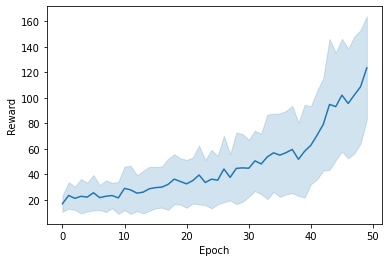

In [22]:
agent = SimpleAgent(config)
agent.train(n_trajectories=50, n_update=50)

Let's evaluate the quality of the learned policy.

In [23]:
agent.evaluate()

Reward: 155.0


**Q.3: What are the strengths and drawbacks of this algorithm? How would you improve it?**

*Type your answer here*

### Don't let the past distract you

- The sum of rewards during one episode has a high variance which affects the performance of this version of **REINFORCE**.
- To assess the quality of an action, it make more sense to take into consideration only the rewards obtained after taking this action.
- It can be proven that $$  \nabla_{\theta} J(\pi_{\theta}) = \mathbb{E}_{\tau \sim \pi_{\theta}}\left[{\sum_{t=0}^{T} \nabla_{\theta} \log \pi_{\theta}(a_t |s_t) \sum_{t'=t}^T \gamma^{t'-t} R(s_{t'}, a_{t'}, s_{t'+1})}\right].$$
- **Bonus**: proof of this claim.
- This has for effect to reduce the variance. Past rewards have zero mean but nonzero variance so they just add noise.  

**Q4: Implement this enhanced version of REINFORCE**

In [24]:
class EnhancedAgent(BaseAgent):
    
    def optimize_model(self, n_trajectories):
        weighted_logproba = torch.zeros(n_trajectories)
        reward_trajectories = np.zeros(n_trajectories)

        for i in range(n_trajectories):
            # New episode
            observation = self.env.reset()
            rewards_episode = []
            logproba_episode = []
            discount_factor = 1
            observation = torch.tensor(observation, dtype=torch.float)
            done = False
            
            while not done:
                action = self.model.select_action(observation)
                logproba_episode.append(torch.log(self.model.forward(observation))[action])
                # Interaction with the environment
                observation, reward, done, info = self.env.step(int(action))
                observation = torch.tensor(observation, dtype=torch.float)
                rewards_episode.append(discount_factor * reward)
                discount_factor *= self.gamma
            
            inverse_cum_rewards = self._make_returns(rewards_episode)
            reward_trajectories[i] = inverse_cum_rewards[0]
            inverse_cum_rewards = torch.tensor(inverse_cum_rewards, dtype=torch.float)
            weighted_logproba[i]= torch.sum(inverse_cum_rewards * torch.cat(logproba_episode))
            
        loss = - weighted_logproba.mean()
        
        self.optimizer.zero_grad()
        # Compute the gradient 
        loss.backward()
        # Do the gradient descent step
        self.optimizer.step()
        return reward_trajectories
   

In [25]:
#@title Config Enhanced {display-mode: "form", run: "auto"}

env_id = 'CartPole-v1'  #@param ["CartPole-v1", "Acrobot-v1", "MountainCar-v0"]
learning_rate = 0.001  #@param {type: "number"}
gamma = 1  #@param {type: "number"}
seed = 1  #@param {type: "integer"}
#@markdown ---

config_enhanced = {
    'env_id': env_id,
    'learning_rate': learning_rate,
    'seed': seed,
    'gamma': gamma
}

print("Current config_enhanced is:")
pprint(config_enhanced)

Current config_enhanced is:
{'env_id': 'CartPole-v1', 'gamma': 1, 'learning_rate': 0.001, 'seed': 1}


Episode 1/50: rewards 20.64 +/- 10.75
Episode 2/50: rewards 17.8 +/- 8.51
Episode 3/50: rewards 18.9 +/- 9.01
Episode 4/50: rewards 17.7 +/- 6.72
Episode 5/50: rewards 20.18 +/- 8.96
Episode 6/50: rewards 18.22 +/- 7.69
Episode 7/50: rewards 18.36 +/- 9.05
Episode 8/50: rewards 18.56 +/- 6.93
Episode 9/50: rewards 17.94 +/- 6.52
Episode 10/50: rewards 19.86 +/- 10.69
Episode 11/50: rewards 19.84 +/- 10.06
Episode 12/50: rewards 19.28 +/- 9.68
Episode 13/50: rewards 21.04 +/- 9.23
Episode 14/50: rewards 20.24 +/- 12.99
Episode 15/50: rewards 19.36 +/- 9.3
Episode 16/50: rewards 18.6 +/- 7.6
Episode 17/50: rewards 19.12 +/- 10.92
Episode 18/50: rewards 20.16 +/- 9.53
Episode 19/50: rewards 20.56 +/- 9.19
Episode 20/50: rewards 22.28 +/- 11.1
Episode 21/50: rewards 21.46 +/- 9.94
Episode 22/50: rewards 20.12 +/- 8.74
Episode 23/50: rewards 20.36 +/- 9.92
Episode 24/50: rewards 22.54 +/- 10.2
Episode 25/50: rewards 20.3 +/- 8.64
Episode 26/50: rewards 20.62 +/- 10.06
Episode 27/50: rewards

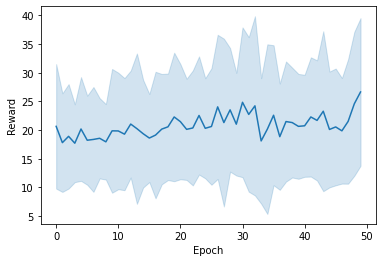

In [26]:
agent = EnhancedAgent(config_enhanced)
agent.train(n_trajectories=50, n_update=50)

In [27]:
agent.evaluate()

Reward: 16.0


**Q.5: Did this method improve over vanilla REINFORCE?**

*Type your answer here*

## A2C

### Theory
The cumulative discounted reward has a high variance and therefore **REINFORCE** needs lots of trajectories to converge.
In order to reduce it we can substract a baseline $b(s_t)$.

This is possible because:

$$\mathbb{E}_{a_t \sim \pi_{\theta}}{\nabla_{\theta} \log \pi_{\theta}(a_t|s_t) b(s_t)} = 0.$$

**Proof**

Let $P_\theta$ be the parameterized probability distribution over a random variable x.
$$\int_x P_\theta (x) = 1$$
Taking the gradient we get: $\nabla_\theta \int_x P_\theta (x) = \nabla_\theta 1 = 0$
\begin{align*}
0 &= \nabla_\theta \int_x P_\theta (x)\\
&= \int_x \nabla_\theta P_\theta(x)\\
&= \int_x P_\theta (x) \nabla_\theta \log P_\theta (x) \\
&= \mathbb{E}_{x \sim P_\theta} \nabla_\theta \log P_\theta (x)
\end{align*}

Which leads to the following formula:

$$ \nabla_{\theta} J(\pi_{\theta}) = \mathbb{E}_{\tau \sim \pi_{\theta}}{\sum_{t=0}^{T} \nabla_{\theta} \log \pi_{\theta}(a_t |s_t) \left(\sum_{t'=t}^T \gamma^{t' - t} R(s_{t'}, a_{t'}, s_{t'+1}) - b(s_t)\right)}$$

The most common choice of baseline is the on-policy value function $V^{\pi}(s_t)$. This choice has the desirable effect of reducing variance in the sample estimate for the policy gradient. This results in faster and more stable policy learning. It is also appealing from a conceptual angle: it encodes the intuition that if an agent gets what it expected, it should “feel” neutral about it.

However $V^\pi$ is unknown and therefore we need to learn it. We will use a neural network to approximate $V^\pi$ with Mean Square Error as the loss function.

$$ \arg \min_{\phi} \mathbb{E}_{s_t, \hat{R}_t \sim \pi_k}{\left( V_{\phi}(s_t) - \hat{R}_t \right)^2}, $$


We can show that we can replace $\sum_{t'=t}^T \gamma^{t' - t} R(s_{t'}, a_{t'}, s_{t'+1})$ in the formula above by $Q^{\pi_\theta}(s_t, a_t)$ and by doing so we finally get $$ \nabla_{\theta} J(\pi_{\theta}) = \mathbb{E}_{\tau \sim \pi_{\theta}}{\sum_{t=0}^{T} \nabla_{\theta} \log \pi_{\theta}(a_t |s_t) \left(Q^{\pi_\theta}(s_t, a_t) - V^{\pi_\theta}(s_t)\right)}$$

**Bonus: Prove the statement above**

$A(s_t, a_t) = Q(s_{t}, a_{t}) - V^\pi(s_t)$ is called the Advantage function which gives the name **Advantage Actor Critic**.

$Q^{\pi_\theta}(s_t, a_t)$ is approximated as the cumulative sum of rewards.

Minh et al. in their paper explained that they added an entropy term to the loss in order to encourage exploration.

$$ - \sum_{a} \pi(a | s) \log \pi(a | s) $$

**Q.6: Explain why adding the entropy term encourage exploration.**

### Coding

In the first part of this lab we had to wait for the end of an episode in order to compute the cumulative discounted rewards. Here we can use the critic to estimate the cumulative discounted reward and therefore we no longer need to wait for the episode termination.

**Example**: For a trajectory $\tau = (s_0, a_0, r_0, s_1, a_1, r_1, ..., s_t, a_t, r_t, ..., s_T, a_T, r_T)$ the cumulative discounted rewards $R(\tau) = \sum_{i=0}^T \gamma^i r_i$ can be approximated by $ \sum_{i=0}^t \gamma^i r_i + \gamma^{t+1} V_\phi(s_{t+1})$ where $V_\phi$ is our critic.

This is allows us to train our model using batch data, which is more efficient for:
* Computing: deep learning libraries (PyTorch, TensorFlow, ...) are optimized for batched data;
* We don't have to wait for the end of a long episode in order to perform the update;
* It is more sample efficient;
* ...


**Q.7: Implement `optimize_model` using batches**

In [28]:
class ActorNetwork(nn.Module):

    def __init__(self, input_size, hidden_size, action_size):
        super(ActorNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, action_size)

    def forward(self, x):
        out = F.relu(self.fc1(x))
        out = F.relu(self.fc2(out))
        out = F.softmax(self.fc3(out), dim=-1)
        return out

In [29]:
class ValueNetwork(nn.Module):

    def __init__(self, input_size, hidden_size, output_size):
        super(ValueNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out = F.relu(self.fc1(x))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

In [30]:
class A2CAgent:

    def __init__(self, config):
        self.config = config
        self.env = gym.make(config['env_id'])
        make_seed(config['seed'])
        self.env.seed(config['seed'])
        self.monitor_env = Monitor(self.env, "./gym-results", force=True, video_callable=lambda episode: True)
        self.gamma = config['gamma']
        
        # Our two networks
        self.value_network = ValueNetwork(self.env.observation_space.shape[0], 16, 1)
        self.actor_network = ActorNetwork(self.env.observation_space.shape[0], 16, self.env.action_space.n)
        
        # Their optimizers
        self.value_network_optimizer = optim.RMSprop(self.value_network.parameters(), lr=config['value_network']['learning_rate'])
        self.actor_network_optimizer = optim.RMSprop(self.actor_network.parameters(), lr=config['actor_network']['learning_rate'])
        
    # Hint: use it during training_batch
    def _returns_advantages(self, rewards, dones, values, next_value):
        """Returns the cumulative discounted rewards at each time step

        Parameters
        ----------
        rewards : array
            An array of shape (batch_size,) containing the rewards given by the env
        dones : array
            An array of shape (batch_size,) containing the done bool indicator given by the env
        values : array
            An array of shape (batch_size,) containing the values given by the value network
        next_value : float
            The value of the next state given by the value network
        
        Returns
        -------
        returns : array
            The cumulative discounted rewards
        advantages : array
            The advantages
        """
        
        returns = np.append(np.zeros_like(rewards), [next_value], axis=0)
        
        for t in reversed(range(rewards.shape[0])):
            returns[t] = rewards[t] + self.gamma * returns[t + 1] * (1 - dones[t])
            
        returns = returns[:-1]
        advantages = returns - values
        return returns, advantages

    def training_batch(self, epochs, batch_size):
        """Perform a training by batch

        Parameters
        ----------
        epochs : int
            Number of epochs
        batch_size : int
            The size of a batch
        """
        episode_count = 0
        actions = np.empty((batch_size,), dtype=np.int)
        dones = np.empty((batch_size,), dtype=np.bool)
        rewards, values = np.empty((2, batch_size), dtype=np.float)
        observations = np.empty((batch_size,) + self.env.observation_space.shape, dtype=np.float)
        observation = self.env.reset()
        rewards_test = []

        for epoch in range(epochs):
            # Lets collect one batch
            for i in range(batch_size):
                observations[i] = observation
                values[i] = self.value_network(torch.tensor(observation, dtype=torch.float)).detach().numpy()
                policy = self.actor_network(torch.tensor(observation, dtype=torch.float))
                actions[i] = torch.multinomial(policy, 1).detach().numpy()
                observation, rewards[i], dones[i], _ = self.env.step(actions[i])

                if dones[i]:
                    observation = self.env.reset()

            # If our epiosde didn't end on the last step we need to compute the value for the last state
            if dones[-1]:
                next_value = 0
            else:
                next_value = self.value_network(torch.tensor(observation, dtype=torch.float)).detach().numpy()[0]
            
            # Update episode_count
            episode_count += sum(dones)

            # Compute returns and advantages
            returns, advantages = self._returns_advantages(rewards, dones, values, next_value)

            # Learning step !
            self.optimize_model(observations, actions, returns, advantages)

            # Test it every 50 epochs
            if epoch % 50 == 0 or epoch == epochs - 1:
                rewards_test.append(np.array([self.evaluate() for _ in range(50)]))
                print(f'Epoch {epoch}/{epochs}: Mean rewards: {round(rewards_test[-1].mean(), 2)}, Std: {round(rewards_test[-1].std(), 2)}')

                # Early stopping
                if rewards_test[-1].mean() > 490 and epoch != epochs -1:
                    print('Early stopping !')
                    break
                observation = self.env.reset()
                    
        # Plotting
        r = pd.DataFrame((itertools.chain(*(itertools.product([i], rewards_test[i]) for i in range(len(rewards_test))))), columns=['Epoch', 'Reward'])
        sns.lineplot(x="Epoch", y="Reward", data=r, ci='sd');
        
        print(f'The trainnig was done over a total of {episode_count} episodes')

    def optimize_model(self, observations, actions, returns, advantages):
        actions = F.one_hot(torch.tensor(actions), self.env.action_space.n)
        returns = torch.tensor(returns[:, None], dtype=torch.float)
        advantages = torch.tensor(advantages, dtype=torch.float)
        observations = torch.tensor(observations, dtype=torch.float)

        # MSE for the values
        self.value_network_optimizer.zero_grad()
        values = self.value_network(observations)
        loss_value = 1 * F.mse_loss(values, returns)
        loss_value.backward()
        self.value_network_optimizer.step()

        # Actor loss
        self.actor_network_optimizer.zero_grad()
        policies = self.actor_network(observations)
        loss_policy = ((actions.float() * policies.log()).sum(-1) * advantages).mean()
        loss_entropy = - (policies * policies.log()).sum(-1).mean()
        loss_actor = - loss_policy - 0.0001 * loss_entropy
        loss_actor.backward()
        self.actor_network_optimizer.step()
        
        return loss_value, loss_actor    

    def evaluate(self, render=False):
        env = self.monitor_env if render else self.env
        observation = env.reset()
        observation = torch.tensor(observation, dtype=torch.float)
        reward_episode = 0
        done = False

        while not done:
            policy = self.actor_network(observation)
            action = torch.multinomial(policy, 1)
            observation, reward, done, info = env.step(int(action))
            observation = torch.tensor(observation, dtype=torch.float)
            reward_episode += reward
            
        env.close()
        if render:
            show_video("./gym-results")
            print(f'Reward: {reward_episode}')
        return reward_episode

**Q.8: Try out different hyperparameters (batch size, learning rate, optimizer, gamma) and identify how each one of them influence the learning.**

In [31]:
#@title Config A2C {display-mode: "form", run: "auto"}

env_id = 'CartPole-v1'  #@param ["CartPole-v1", "Acrobot-v1", "MountainCar-v0"]
value_learning_rate = 0.001  #@param {type: "number"}
actor_learning_rate = 0.001  #@param {type: "number"}
gamma = 1  #@param {type: "number"}
entropy = 1  #@param {type: "number"}
seed = 1  #@param {type: "integer"}
#@markdown ---

config_a2c = {
    'env_id': env_id,
    'gamma': gamma,
    'seed': seed,
    'value_network': {'learning_rate': value_learning_rate},
    'actor_network': {'learning_rate': actor_learning_rate},
    'entropy': entropy
}

print("Current config_a2c is:")
pprint(config_a2c)

Current config_a2c is:
{'actor_network': {'learning_rate': 0.001},
 'entropy': 1,
 'env_id': 'CartPole-v1',
 'gamma': 1,
 'seed': 1,
 'value_network': {'learning_rate': 0.001}}


Epoch 0/1000: Mean rewards: 22.06, Std: 10.92
Epoch 50/1000: Mean rewards: 36.66, Std: 22.2
Epoch 100/1000: Mean rewards: 59.52, Std: 35.29
Epoch 150/1000: Mean rewards: 82.24, Std: 33.12
Epoch 200/1000: Mean rewards: 178.82, Std: 94.29
Epoch 250/1000: Mean rewards: 175.08, Std: 70.4
Epoch 300/1000: Mean rewards: 313.68, Std: 116.94
Epoch 350/1000: Mean rewards: 330.34, Std: 124.18
Epoch 400/1000: Mean rewards: 210.58, Std: 73.45
Epoch 450/1000: Mean rewards: 421.44, Std: 120.49
Epoch 500/1000: Mean rewards: 422.68, Std: 94.28
Epoch 550/1000: Mean rewards: 430.98, Std: 97.52
Epoch 600/1000: Mean rewards: 440.26, Std: 103.91
Epoch 650/1000: Mean rewards: 455.7, Std: 79.38
Epoch 700/1000: Mean rewards: 473.26, Std: 67.93
Epoch 750/1000: Mean rewards: 471.92, Std: 66.68
Epoch 800/1000: Mean rewards: 425.78, Std: 104.92
Epoch 850/1000: Mean rewards: 465.4, Std: 84.26
Epoch 900/1000: Mean rewards: 405.8, Std: 115.81
Epoch 950/1000: Mean rewards: 460.46, Std: 85.71
Epoch 999/1000: Mean rewar

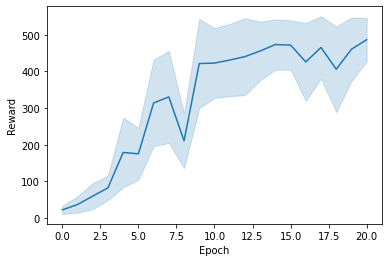

In [32]:
agent = A2CAgent(config_a2c)
rewards = agent.training_batch(1000, 256)

In [33]:
agent.evaluate(True);

Reward: 500.0


**Q.9: What are the strengths and drawbacks of this algorithm? How would you improve it?**

*Type your answer here*

**Q.10: Compare the three algorithms (sample efficiency, stability, ...)**

*Type your answer here*

Make sure to try the algorithms with other environments!